# Optimisation topologique d'un transformateur
___
___

## Présentation de l'activité

Ce notebook est une introduction à l'*optimisation topologique* dans le domaine de l'électrotechnique. L'objectif est de répartir au mieux du fer entre deux bobines, afin d'en maximiser le couplage magnétique. 

On utilisera la **méthode des densités**, qui représente la répartition de matière par un champ de "densité" $\rho$ :
- lorsque $\rho(x) = 1$, alors le matériau au point $x$ est supposé être du fer
- lorsque $\rho(x) = 0$, on l'interprète comme de l'air. 

Une valeur intermédiaire de $\rho$ correspond à un mélange de fer et d'air, ce qu'on souhaite éviter. L'algorithme d'optimisation va donc progressivement ajuster le champ de densité à partir d'une situation initiale donnée. La répartition de matière va progressivement évoluer jusqu'à atteindre une géométrie facilement identifiable, comme sur l'exemple ci-dessous (généré avec [*A 99 line topology optimization code written in Matlab*, O. Sigmund, 2001](https://link.springer.com/article/10.1007/s001580050176)):

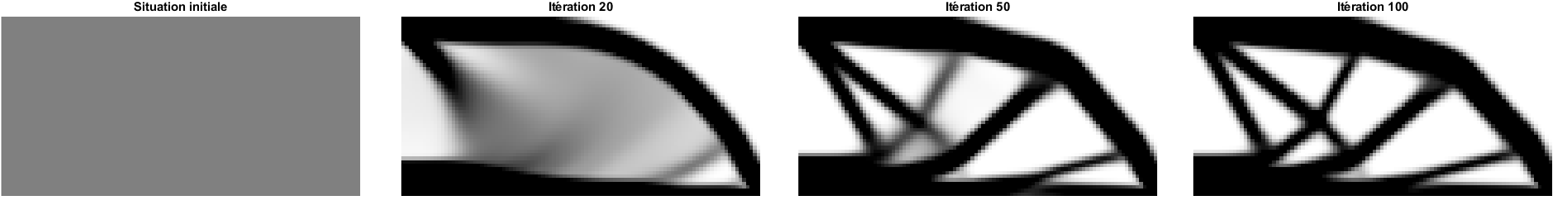

Une méthode d'optimisation topologique à densité se décompose en trois étapes :
1. [**Calcul de l'état direct**](#FEM), qui est le champ *physique* (*induction magnétique*). Ce calcul peut se faire par la méthode des **éléments finis** ;
2. [**Calcul de l'état adjoint**](#AVM), afin de permettre l'évaluation efficace du **gradient** de la fonction objectif choisie ;
3. Mise à jour du champ de densité dans [**l'algorithme d'optimisation**](#algo) .



Les cellules de code à compléter seront précédées de l'indication <***<font color='red'>compléter</font>***>. Lorsque la cellule est déjà complète, et n'a qu'à être exécutée, elle sera précédée de l'indication <***<font color='green'>exécuter</font>***>. Même si la cellule n'a pas besoin d'être complétée, vous pouvez lire le code et les commentaires qu'elle contient ; par ailleurs vous pouvez modifier le code à votre guise.

Tout d'abord, on importe les modules et les fonctions dont on aura besoin :

 <***<font color='green'>exécuter</font>***> 

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from IPython.display import clear_output

___

## 1) Calcul de l'état direct : méthode des éléments finis
<a id='FEM'></a>
### 1.a) Maillage

La première étape consiste à calculer le champ magnétique pour une répartition de matière donnée. Pour cela, on commence par définir et discrétiser l'espace de simulation. C'est l'étape de **maillage**. NgSolve comporte NetGen, un outil de maillage intégré. Pour plus d'informations sur son utilisation, consulter [ce lien](https://docu.ngsolve.org/latest/netgen_tutorials/define_2d_geometries.html). L'espace est divisé en plusieurs zones, représentées sur la figure suivante :

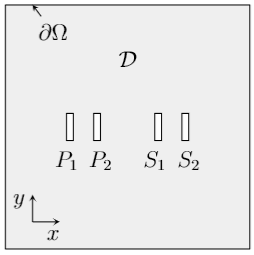

On adopte les notations suivantes :
- $\mathcal{D}$ désigne l'espace de design, sur lequel on va déterminer la répartition de matière optimisée
- $P_1$ et $P_2$ désignent les conducteurs de la bobine primaire 
- $S_1$ et $S_2$ désignent les conducteurs de la bobine secondaire 
- $\Omega = \mathcal{D} \cup P_1 \cup P_2 \cup S_1 \cup S_2 $ désigne l'espace de simulation tout entier
- $\partial \Omega$ désigne le bord du domaine de simulation

 <***<font color='green'>exécuter</font>***>

In [2]:
taille_max_element = 0.2 # taille maximale d'un élément de maillage

## Génération de la géométrie

geo = SplineGeometry()

# La géométrie de notre problème est très simple : un carré qui délimite l'espace de simulation,
# ainsi que des rectangles qui correspondent aux conducteurs des bobines primaire et secondaire.

# Domaine de simulation : 

geo.AddRectangle( p1 = (-3, -3), p2 = (3, 3), leftdomain = 1, rightdomain = 0,
                 bcs = ("right", "top", "left", "bot") )

# bcs = "boundary conditions" -> il s'agit d'identifier les bords du domaine et de les nommer, afin
# d'y appliquer des conditions limites plus tard.

# Conducteurs : 

geo.AddRectangle( p1 = (-1.1, -0.2), p2 = (-1, 0.2), leftdomain = 2, rightdomain = 1 )
geo.AddRectangle( p1 = (-0.6, -0.2), p2 = (-0.5, 0.2), leftdomain = 3, rightdomain = 1 )
geo.AddRectangle( p1 = (0.5, -0.2), p2 = (0.6, 0.2), leftdomain = 4, rightdomain = 1 )
geo.AddRectangle( p1 = (1, -0.2), p2 = (1.1, 0.2), leftdomain = 5, rightdomain = 1 )

# On nomme les différentes zones afin de les repérer plus tard :

geo.SetMaterial( 1, "D" )       # zone de design
geo.SetMaterial( 2, "P1" )      # conducteur primaire positif
geo.SetMaterial( 3, "P2" )      # conducteur primaire négatif
geo.SetMaterial( 4, "S1" )      # conducteur secondaire positif
geo.SetMaterial( 5, "S2" )      # conducteur secondaire négatif

## Discrétisation et tracé du maillage

ngmesh = geo.GenerateMesh( maxh = taille_max_element ) # Maillage avec NetGen
mesh = Mesh( ngmesh )    # Importation du maillage NetGen dans NgSolve
Draw( mesh )             # Tracé du maillage obtenu

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

___
### 1.b) Formulation variationnelle - problème direct

L'équation *forte* de la magnétostatique 2D dans $\Omega$ tout entier s'écrit :

$$ \text{div} (  \nu ~ \overrightarrow{\text{grad}} ~ a )  = j $$

Avec $\nu = \frac{h}{b}$ le champ de réluctivité magnétique (inverse de la perméabilité), $a$ la composante du potentiel vecteur magnétique selon l'axe $z$ et $j$ la densité de courant. On considère des conditions limites de Dirichlet : $a=0$ sur $\partial \Omega$. On peut montrer que la solution de cette équation associée à ce type de conditions limites est la seule qui annule la *forme variationnelle* suivante : 

$$ \forall a^* \in \mathcal{H}^1_0 (\Omega), \quad \mathcal{F}(a^*,a) = \underbrace{\int_\Omega \overrightarrow{\text{grad}}~ a^* \cdot  \nu ~ \overrightarrow{\text{grad}}~a}_{\text{forme bilinéaire de $(a^*,a)$}} - \underbrace{\int_\Omega a^* j}_{\text{forme linéaire de $a^*$}} = 0$$

On appelle $a^*$ une **fonction test** ("test function"), $a$ étant le champ inconnu ("trial function"). On supposera par ailleurs la linéarité du fer, c'est-à-dire que $\nu$ est indépendant de $a$. Il faut maintenant implémenter cette formulation variationnelle dans NgSolve. Il faut définir dans l'ordre : 
1. L'*espace fonctionnel* $\mathcal{H}^1_0(\Omega) = \{a\in \mathcal{H}^1, a = 0 ~\text{sur}~ \partial \Omega \}$ dans lequel on travaille
2. La *forme bilinéaire* : $\int_\Omega \overrightarrow{\text{grad}}~ a^* \cdot  \nu ~ \overrightarrow{\text{grad}}~a$, qui s'interprète une fois discrétisée comme la matrice éléments finis $K$
3. La *forme linéaire* : $\int_\Omega a^* j$ qui une fois discrétisée donne le vecteur second membre $s$. On suppose que seule la bobine primaire est alimentée.

Des informations sur la syntaxe NgSolve peuvent être trouvée dans ce [notebook](2-BaseNgSolve.ipynb#NGSolve), ainsi que sur [la documentation](https://docu.ngsolve.org/latest/i-tutorials/unit-1.3-dirichlet/dirichlet.html)

<***<font color='red'>à compléter</font>***> (**Question 5**)

In [3]:
jz = 10e6; # amplitude de la densité de courant dans les conducteurs

def solveMag(nu):
    
    # 1) définition de l'espace fonctionnel
    fes = H1(mesh, order=1, dirichlet="right|top|left|bot") # à compléter
    a = fes.TrialFunction()
    a_star = fes.TestFunction()
    
    # 2) Définition de la forme bilinéaire
    K = BilinearForm(fes, symmetric=True)
    K += grad(a_star)*nu*grad(a)*dx # à compléter

    # 3) Définition de la forme linéaire
    s = LinearForm(fes)
    s += a_star*jz*dx("P1") - a_star*jz*dx("P2") # à compléter
    
    # 3) Assemblage -> on sort du monde continu pour discrétiser et obtenir le système K * a = s
    K.Assemble() # K est désormais une matrice
    s.Assemble() # s est désormais un vecteur
    
    # 4) Résolution -> la solution formelle s'écrit a = K^-1 * s 
    # (en réalité l'inverse n'est pas explicitement calculée, on utilise une décomposition de Cholesky)
    
    state = GridFunction(fes)  # On déclare que la solution est une fonction définie point par point.
    state.vec.data = K.mat.Inverse(inverse="sparsecholesky",
                                          freedofs=fes.FreeDofs()) * s.vec
    return state

Afin de vérifier la résolution du problème physique, on teste `solveMag` sur un problème simple, où $\nu = \nu_0$ partout.

 <***<font color='green'>exécuter</font>***>

In [4]:
nu0 = 1/(4e-7 * np.pi) 
a0 = solveMag(nu0)
Draw(a0,mesh) # On trace la composante selon z du potentiel vecteur

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Il est plus commode de visualiser l'induction magnétique, qui s'écrit en 2D :

$$ \vec{b} = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix} \overrightarrow{\text{grad}} ~ a $$

Vérifiez que l'induction est orienté dans le sens prévu.

 <***<font color='red'>à compléter</font>***> (**Question 6**)

In [5]:
# Tracé du champ magnétique :

def bField(state):
    return CoefficientFunction((grad(state)[1],-grad(state)[0])) # à compléter

Draw(bField(a0), mesh, vectors = { "grid_size":20})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

___
### 1.c) Fonction objectif

On veut évaluer le flux qui traverse la bobine secondaire. Le flux magnétique qui passe entre deux points $A$ et $B$ (il s'agit d'une surface dans une simulation 2D) est proportionnel à $a(A) - a(B)$ ; son signe est déterminé par la règle du tire-bouchon. Le flux passant par la bobine secondaire peut alors s'écrire :

$$ \phi(a) = \int_{S_2} a - \int_{S_1} a $$

Implémenter cette fonction dans NgSolve, et vérifier son bon fonctionnement.

<***<font color='red'>compléter</font>***> (**Questions 9 - 10**)

In [6]:
def fluxMoyen(state):
    return Integrate ( state, mesh.Materials("S2") )-Integrate ( state, mesh.Materials("S1") ) 


def fObjectif(state):
    return - fluxMoyen(state)

fObjectif(a0)

-0.0003870429281089059

___
___
## 2) Calcul du gradient
<a id='AVM'></a>

Il est temps de définir le champ de densité $\rho$ sur $\Omega_o$, qu'on cherche à ajuster pour résoudre le problème d'optimisation suivant :

$$\begin{array}{ll}
\text{Trouver :} & \rho_{\text{opt}} = \arg \min f(a(\rho)) \\
\text{Sous contrainte :}&  \forall x \in \mathcal{D}, \rho(x) \in [0,1]
\end{array}$$

Ce problème peut-être résolu par un algorithme de **descente de gradient**. L'objectif de cette section est donc de calculer le gradient $\nabla_\rho f$.

___

### 2.a) Interpolation $\rho \mapsto \nu$

Tout d'abord, il faut définir le lien entre *le champ de densité* $\rho$ et les propriétés matériaux. Dans le cas présent, on cherche à répartir du fer et de l'air, la seule différence se situe au niveau de la réluctivité :
- la réluctivité de l'air vaut $\nu_0 = \frac{1}{\mu_0}$
- la réluctivité du fer est bien plus faible, et sera fixée à $\nu_f = \frac{\nu_0}{1000}$

Les valeurs extrêmes de *l'interpolation* $\rho \mapsto \nu$ sont imposées :
- $\nu(\rho = 0) = \nu_0$
- $\nu(\rho = 1) = \nu_f$

Il existe une grande liberté pour les valeurs de réluctivité intermédiaire. On choisit d'utiliser la fonction d'interpolation suivante, inspirée de la RAMP proposée par [Stolpe & Svanberg, 2001](https://link.springer.com/article/10.1007/s001580100129)) :

$$ \nu : \left \{ \begin{array}{ccc}
[0,1] & \rightarrow &[\nu_f,\nu_0] \\
\rho & \mapsto & \nu_0 + (\nu_f-\nu_0) \frac{\rho}{q - q \cdot \rho +1}\end{array} \right. $$

Avec $q$ un paramètre de *pénalisation* supérieur ou égal à 0. Il faut donc coder cette fonction.

<***<font color='red'>compléter</font>***> (**question 11**)

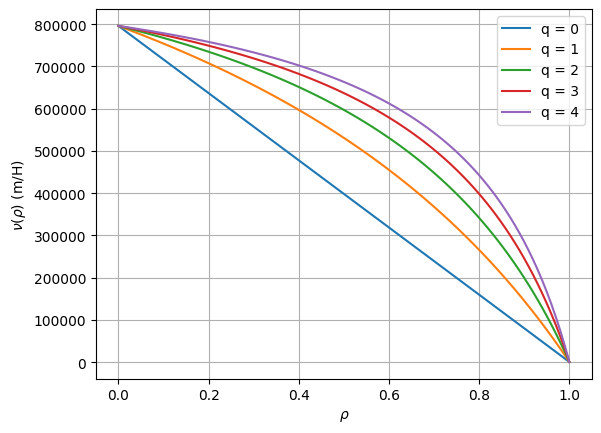

In [7]:
q = 0
nu0 = 1/(4e-7*np.pi)
nu_f = nu0/1000

def rho2nu(rho):
    return nu0 + (nu_f-nu0)*rho/(q-q*rho+1) # à compléter


# Tracé pour vérifier :

for q in range(5):
    plt.plot(np.linspace(0,1,100), rho2nu(np.linspace(0,1,100)), label = f'q = {q}')
    
plt.xlabel(r'$\rho$') ; plt.ylabel(r'$\nu(\rho)$ (m/H)')
plt.grid() ; plt.legend()
plt.show()

# On fixe désormais q à 0 pour la suite :
q = 0

Il faut aussi calculer la dérivée de `rho2nu`, qui va intervenir dans le calcul du gradient.

<***<font color='red'>compléter</font>***> (**question 12**)

In [8]:
def dnuDrho(rho):
    return (nu_f-nu0)*(q+1)/(q-q*rho+1)**2 # à compléter

Désormais, pour résoudre le problème éléments finis associé à la répartition de matière $\rho$, il faut appeler `solveMag(rho2nu(rho))`.
___
### 2.b) Calcul de l'état adjoint

La difficulté du calcul de $\nabla_\rho f$ est que la dépendance de $f$ vis-à-vis de $\rho$ est **implicite**. En effet, on sait calculer $f$ à partir d'un champ physique $a$, et ce champ dépend de la répartition de matière $\rho$ via l'annulation de la formulation variationnelle $\mathcal{F}$. Autrement dit, on n'a **pas d'expression explicite** de la fonction $\rho \mapsto a$, car pour trouver $a(\rho)$, il faut résoudre le problème éléments finis. On n'a donc pas non plus d'expression de $\frac{\mathrm{d} a}{\mathrm{d}\rho}$, ce qui rend le calcul de $\nabla_\rho f$ délicat.

Pour contourner cette difficulté, on introduit un degré de liberté supplémentaire en définissant le **Lagrangien** suivant :

$$ \mathcal{L}(a,a^*,\rho) = \underbrace{\int_{S_1} a - \int_{S_2} a}_{f(a)}  + \underbrace{\int_\Omega \overrightarrow{\text{grad}}~ a^* \cdot  \nu(\rho) ~ \overrightarrow{\text{grad}}~a - \int_\Omega a^* j}_{\mathcal{F}(a,a^*,\rho)} $$

Si $a$ est l'état physique, alors par définition il dépend de $\rho$ et annule $\mathcal{F}(a,a^*,\rho)$. Dans ce cas, on a l'égalité :

$$ \forall a^*\in \mathcal{H}^1_0(\Omega), \quad  f(a(\rho)) = \mathcal{L}(a(\rho),a^*,\rho)  $$

$$ \Rightarrow  \forall a^*\in \mathcal{H}^1_0(\Omega), \quad  \frac{\mathrm{d}f}{\mathrm{d} \rho} =  \frac{\mathrm{d}\mathcal{L}}{\mathrm{d} \rho} = \underbrace{\frac{\partial \mathcal{L}}{\partial \rho}}_{\text{Calculable}} + \frac{\partial \mathcal{L}}{\partial a} \cdot \underbrace{\frac{\mathrm{d} a}{\mathrm{d}\rho}}_{\text{Inconnu}} $$

L'objectif est donc de trouver une valeur particulière de $a^*$ qui permet d'annuler $\frac{\partial \mathcal{L}}{\partial a}$, afin de ne pas avoir à évaluer le terme $\frac{\mathrm{d} a}{\mathrm{d}\rho}$. Cette valeur particulière de $a^*$ est appelée **l'état adjoint**, et sera notée $\lambda$. On peut montrer que cette grandeur annule la formulation variationnelle suivante :

$$ \forall a^* \in \mathcal{H}^1_0(\Omega), \quad \int_{S_1} a^* - \int_{S_2} a^* + \int_\Omega \overrightarrow{\text{grad}}~ \lambda \cdot \nu(\rho) ~ \overrightarrow{\text{grad}}~ a^* =0 $$

Cette expression peut s'implémenter dans NgSolve. On peut constater que le problème n'est pas auto-adjoint, c'est à dire que $\lambda$ n'est pas proportionnel à $a$.

<***<font color='red'>compléter</font>***> (**question 14**)

In [9]:
def solveAdjointState(nu):
    
    # 1) définition de l'espace fonctionnel
    fes = H1(mesh, order=1, dirichlet="right|top|left|bot") # à compléter
    lambd = fes.TrialFunction()
    a_star = fes.TestFunction()
    
    # 2) Définition de la forme bilinéaire
    K = BilinearForm(fes, symmetric=True)
    K += grad(lambd)*nu*grad(a_star)*dx # à compléter

    # 3) Définition de la forme linéaire
    s = LinearForm(fes)
    s += a_star*dx("S2") - a_star*dx("S1") # à compléter
    
    # 3) Assemblage -> on sort du monde continu pour discrétiser et obtenir le système K * a = s
    K.Assemble() # K est désormais une matrice
    s.Assemble() # s est désormais un vecteur
    
    # 4) Résolution -> la solution formelle s'écrit a = K^-1 * s 
    # (en réalité l'inverse n'est pas explicitement calculée)
    
    adjointState = GridFunction(fes)  # On déclare que la solution est une fonction définie point par point.
    adjointState.vec.data = K.mat.Inverse(inverse="sparsecholesky",
                                          freedofs=fes.FreeDofs()) * s.vec
    return adjointState

adjoint = solveAdjointState(nu0)
Draw(adjoint)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

___
### 2.c) Calcul du gradient

Une fois l'état direct $a(\rho)$ et l'état adjoint $\lambda$ calculés, l'expression de la dérivée de la fonction objectif par rapport à une perturbation du champ de densité $\rho$ s'écrit:

$$ \frac{\mathrm{d}f}{\mathrm{d} \rho} = \frac{\partial \mathcal{L}(a(\rho),\lambda,\rho)}{\partial \rho}  $$

Ce qui correspond à l'expression intégrale suivante :

$$ \frac{\mathrm{d}f}{\mathrm{d} \rho} =  \int_{\Omega} \overrightarrow{\text{grad}}~ \lambda \cdot  \frac{\partial \nu}{\partial \rho} ~ \overrightarrow{\text{grad}}~a(\rho) \overbrace{=}^{\frac{\partial \nu}{\partial \rho} = 0 ~\text{en dehors de}~\mathcal{D}} \int_{\mathcal{D}} \overrightarrow{\text{grad}}~ \lambda \cdot  \frac{\partial \nu}{\partial \rho} ~ \overrightarrow{\text{grad}}~a(\rho) $$

Si on s'intéresse à une perturbation de type Dirac pour *chaque point* $x\in\mathcal{D}$, on peut écrire :
$$ \frac{\mathrm{d}f}{\mathrm{d} \rho_x} =  \int_{\mathcal{D}} \overrightarrow{\text{grad}}~ \lambda \cdot  \frac{\partial \nu}{\partial \rho} \delta_x  ~ \overrightarrow{\text{grad}}~a(\rho) = \overrightarrow{\text{grad}} ~\lambda(x) \cdot  \frac{\partial \nu(x)}{\partial \rho}  ~ \overrightarrow{\text{grad}}~a(x) $$

On identifie alors le gradient en tout point par le champ scalaire suivant :

$$ \nabla_\rho f =  \overrightarrow{\text{grad}}~ \lambda \cdot  \frac{\partial \nu}{\partial \rho}  ~ \overrightarrow{\text{grad}}~a $$

On peut définir et tracer ce champ dans NgSolve.

<***<font color='red'>compléter</font>***> (**question 16**)

In [10]:
def gradRho(state,adjointState,dnudrho):
    return grad(adjointState) * (dnudrho * grad(state))  # à compléter

Draw(gradRho(a0,adjoint,dnuDrho(0)),mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

___
___
## 3) Algorithme d'optimisation

Le gradient $\nabla_\rho f$ calculé à la section précédente s'interprète comme la direction qui maximise l'augmentation de $f$. Pour minimiser $f$, il faut donc faire évoluer le champ de densité $\rho$ de la façon suivante : 
- Aux endroits où $\nabla_\rho f>0$, il faut **diminuer** $\rho$
- Aux endroits où $\nabla_\rho f<0$, il faut **augmenter** $\rho$

Cette constatation va servir de base pour l'algorithme d'optimisation. Il faut cependant prendre garde à plusieurs choses :
- $\nabla_\rho f$ seule ne donne aucune indication sur la taille de la variation de $\rho$ : il s'agit du **pas** de l'optimisation, qu'on appellera $\alpha$
- $\rho$ doit toujours rester compris entre 0 et 1
- L'algorithme doit avoir une fin.

### 3.a) Descente de gradient avec adaptation du pas

Lorsque le pas $\alpha$ est trop grand, il y a un risque de "rater" un optimum.
Pour palier à ce problème, on propose de contrôler l'évolution de la fonction objectif et d'adapter le pas en conséquence à l'aide de l'algorithme suivant :

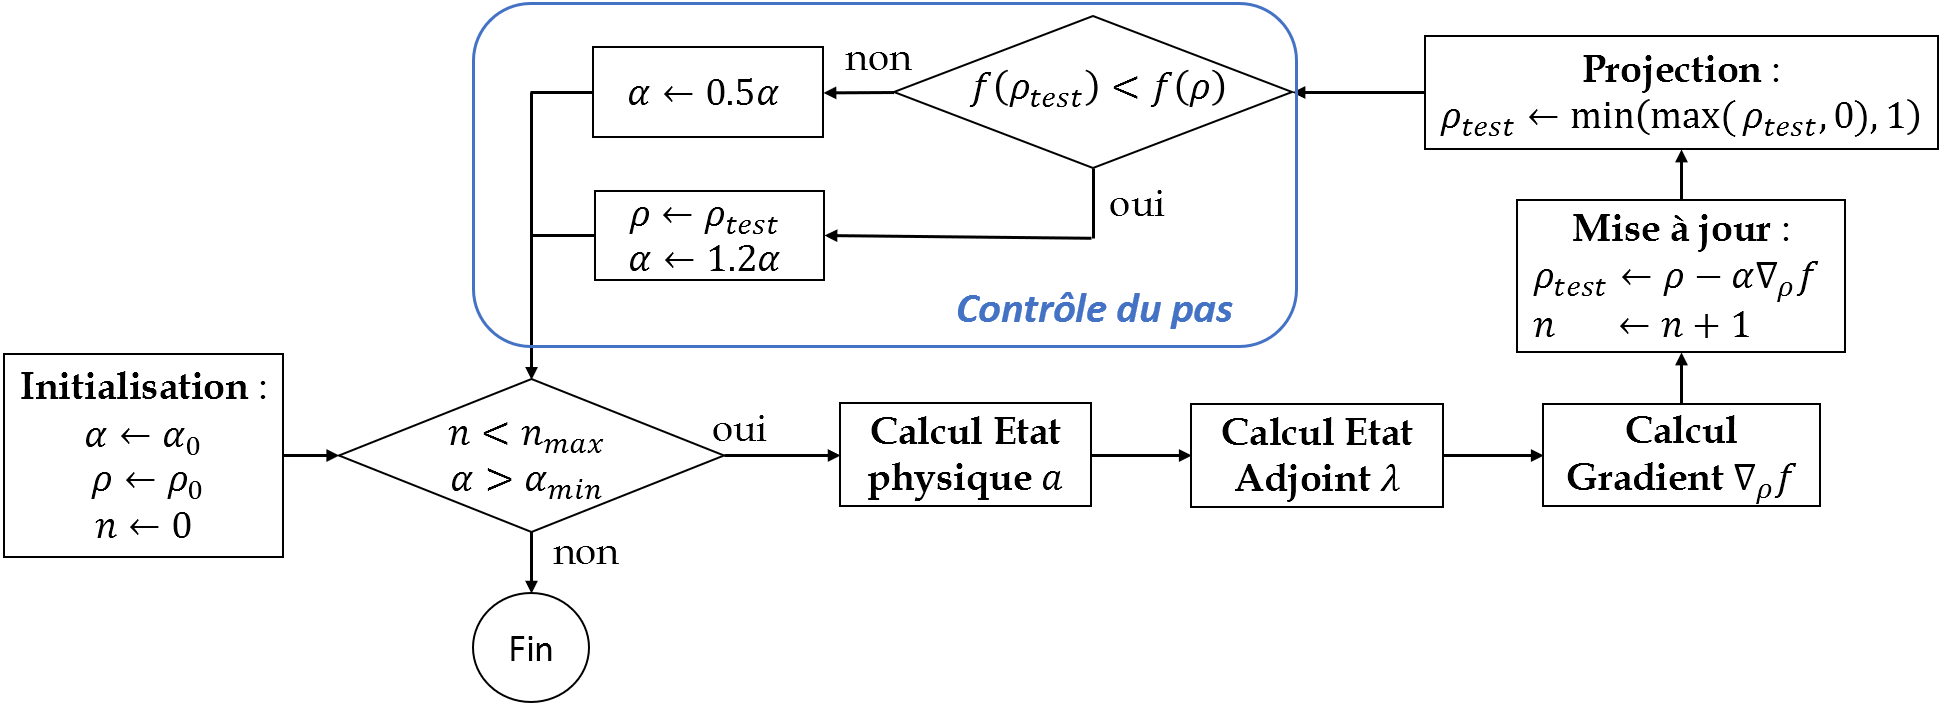

<***<font color='green'>exécuter</font>***>

In [11]:
## Initialisation

rho0 = 0.5;       # Valeur initiale du champ rho (à faire varier)
alpha = 100       # Pas initial
alpha_min = 1e-4  # Pas minimal
n_max = 1000        # Nombre d'itérations de l'algorithme d'optimisation
n = 0

# Définition de la situation initiale
spaceRho = L2(mesh)
rho = GridFunction(spaceRho)
D = GridFunction(spaceRho)
D.Set(mesh.MaterialCF({ "D" : 1}, default=0))
rho.Set(mesh.MaterialCF({ "D" : rho0}, default=0))
rho.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==1] = rho0

objectiveHistory = [fObjectif(solveMag(rho2nu(rho)))]
rhoHistory = [copy(rho)]

# Tracé du champ de densité initial
Draw(rho, min=0, max=1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

<***<font color='red'>compléter</font>***> (**question 17**)

In [12]:
## Boucle d'optimisation (descente de gradient avec contrôle du pas)

while( n < n_max and alpha > alpha_min):
    
    # 1) Calcul de l'état physique :
    directState = solveMag(rho2nu(rho))
    
    # 2) Calcul de l'état adjoint :
    adjointState = solveAdjointState(rho2nu(rho))
    
    # 3) Calcul du gradient :
    gradient = gradRho(directState,adjointState,dnuDrho(rho))
    
    # 3) Mise à jour :
    rho_test = GridFunction(spaceRho)
    rho_test.Set(rho - alpha * gradient) # à compléter
    n += 1
    
    # 4) Projection :
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
    rho_test.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==0] = 0
    
    # 5) Contrôle du pas :
    a_test = solveMag(rho2nu(rho_test))
    objectiveHistory.append(fObjectif(a_test))
    clear_output(wait = True)
    
    print(f'it n°{n} | f = {objectiveHistory[-1]}')
    
    if objectiveHistory[-1] >= objectiveHistory[-2]:
        alpha = alpha/2
        objectiveHistory.pop();
    elif objectiveHistory[-1] < objectiveHistory[-2]:
        alpha = alpha*1.2
        rho = rho_test
        rhoHistory.append(copy(rho))

it n°90 | f = -2.949776350827548


In [13]:
# Résultat d'optimisation
Draw(rho, min = 0, max = 1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

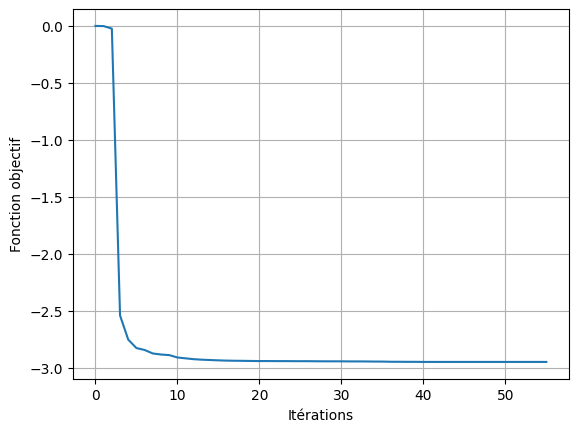

In [14]:
# Evolution de la fonction objectif au cours de l'optimisation
plt.plot(objectiveHistory)   
plt.xlabel('Itérations')
plt.ylabel('Fonction objectif')
plt.grid() ; plt.show()

___
### 3.b) Contrainte de masse

Comme on le constate, la structure obtenue est très massive. Cette masse peut s'exprimer comme *l'intégrale du champ de densité*, qu'on normalise par la masse maximale :

$$ m = \frac{\int_\Omega \rho}{\int_\Omega 1} $$

Codons cette expression ainsi que sa dérivée par rapport à $\rho$ :

<***<font color='red'>compléter</font>***> (**question 18**)

In [15]:
def mass(rho):
    return Integrate(rho, mesh)/Integrate(CoefficientFunction((1)), mesh)

def dmassdrho(rho):
    return CoefficientFunction((1))/Integrate(CoefficientFunction((1)), mesh)

Le problème d'optimisation sous contrainte s'écrit alors :

$$\begin{array}{ll}
\text{Trouver :} & \rho_{opt} = \arg \min f(a(\rho)) \\
\text{Sous contrainte :} & \rho \in [0,1] \\
& m(\rho) = 0.1
\end{array}$$

Il existe plusieurs méthodes pour résoudre ce type de problème. La plus simple est d'introduire un terme de pénalisation, nul lorsque la contrainte est respectée et grand ailleurs. Par exemple, lorsque la fraction massique cible vaut $0.1$ :

$$\begin{array}{ll}
\text{Trouver :} & \rho_{opt} = \arg \min f(a(\rho)) + \beta (m(\rho)-0.1)^2 \\
\text{Sous contrainte :} & \rho \in [0,1] \\
\end{array}$$

Modifier le code initial afin de prendre en compte ce terme, et ajustez la valeurs de $\beta$ jusqu'à obtenir un résultat satisfaisant.

<***<font color='green'>exécuter </font>***> (**question 19**)

In [16]:
## Initialisation

mass_target = 0.1 # Fraction massique cible
beta = 1          # Coefficient de pénalisation
rho0 = 0.5;       # Valeur initiale du champ rho (à faire varier)
alpha = 100       # Pas initial
alpha_min = 1e-4  # Pas minimal
n_max = 1000        # Nombre d'itérations de l'algorithme d'optimisation
n = 0

# Définition de la situation initiale
spaceRho = L2(mesh)
rho = GridFunction(spaceRho)
D = GridFunction(spaceRho)
D.Set(mesh.MaterialCF({ "D" : 1}, default=0))
rho.Set(mesh.MaterialCF({ "D" : rho0}, default=0))
rho.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==1] = rho0

objectiveHistory = [fObjectif(solveMag(rho2nu(rho))) + beta * (mass(rho) - mass_target)**2]
rhoHistory = [copy(rho)]
massHistory = [mass(rho)]

# Tracé du champ de densité initial
Draw(rho, min=0, max=1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [17]:
## Boucle d'optimisation (contrainte de masse par pénalisation)

while ( n < n_max and alpha > alpha_min):
    
    # 1) Calcul de l'état physique :
    directState = solveMag(rho2nu(rho))
    
    # 2) Calcul de l'état adjoint :
    adjointState = solveAdjointState(rho2nu(rho))
    
    # 3) Calcul du gradient :
    gradient = gradRho(directState,adjointState,dnuDrho(rho)) + 2* beta * dmassdrho(rho) * (mass(rho) - mass_target)
    
    # 3) Mise à jour :
    rho_test = GridFunction(spaceRho)
    rho_test.Set(rho - alpha * gradient)
    n += 1
    
    # 4) Projection :
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
    rho_test.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==0] = 0
    
    # 5) Contrôle du pas :
    a_test = solveMag(rho2nu(rho_test))
    objectiveHistory.append(fObjectif(a_test)+ beta * (mass(rho_test) - mass_target)**2)
    massHistory.append(mass(rho_test))
    clear_output(wait = True)
    
    print(f'it n°{n} | f = {objectiveHistory[-1]} | m = {massHistory[-1]}')
    
    if objectiveHistory[-1] >= objectiveHistory[-2]:
        alpha = alpha/2
        objectiveHistory.pop(); massHistory.pop();
    elif objectiveHistory[-1] < objectiveHistory[-2]:
        alpha = alpha*1.2
        rho = rho_test
        rhoHistory.append(copy(rho))

it n°134 | f = -2.552405498308871 | m = 0.10639243545742944


In [18]:
# Résultat d'optimisation
Draw(rho, min = 0, max = 1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

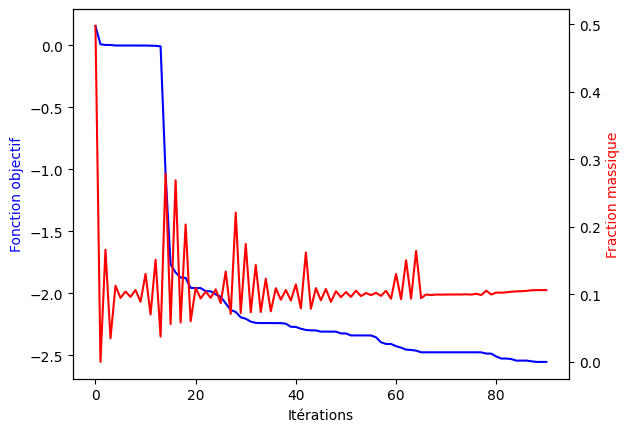

In [19]:
# Evolution de la fonction objectif et de la masse au cours de l'optimisation

ax1 = plt.plot(objectiveHistory, color = 'b')   
plt.ylabel('Fonction objectif', color = 'b')
plt.xlabel('Itérations')
ax2 = plt.gca().twinx()
ax2.plot(massHistory, color = 'r')
plt.ylabel('Fraction massique', color = 'r')
plt.show()

___
### 3.b) Inversion du sens du flux

Le résultat obtenu n'est pas surprenant, et s'interprète facilement, mais on peut s'amuser à tester l'algorithme pour des situations non-conventionnelle. Par exemple, comment le fer serait-il réparti si ou souhaite inverser le sens du flux dans la bobine secondaire, sans toucher aux bobinages ?

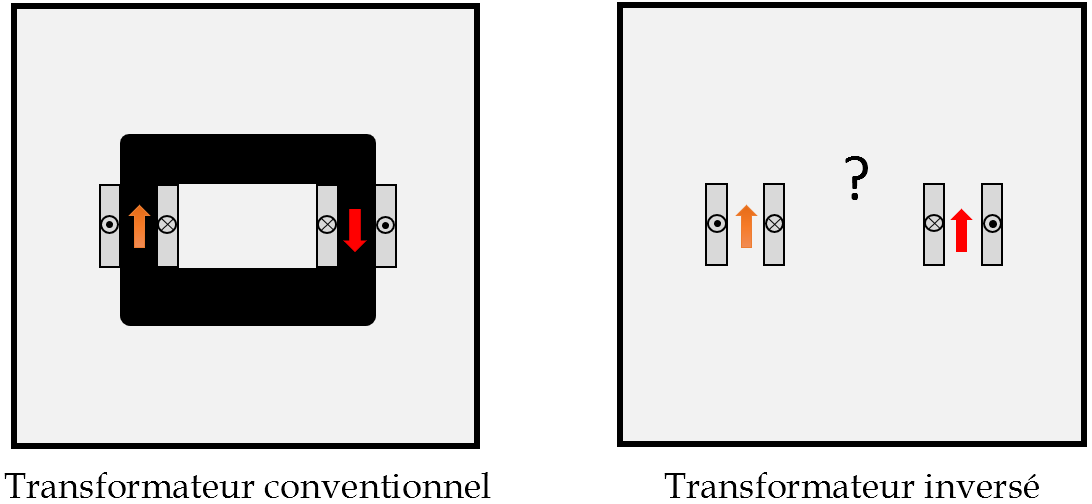

D'abord, codons cette fonction objectif alternative, ainsi que la fonction qui calcule l'état adjoint qui lui est associé :

<***<font color='red'>compléter</font>***> (**question 21**)

In [20]:
def fObjectif2(state):
    return - Integrate ( state, mesh.Materials("S1") ) + Integrate ( state, mesh.Materials("S2") ) 

def solveAdjointState2(nu):
    # 1) définition de l'espace fonctionnel
    
    fes = H1(mesh, order=1, dirichlet="right|top|left|bot") # à compléter
    lambd = fes.TrialFunction()
    a_star = fes.TestFunction()
    
    # 2) Définition de la forme bilinéaire
    
    K = BilinearForm(fes, symmetric=True)
    K += grad(lambd)*nu*grad(a_star)*dx # à compléter

    # 3) Définition de la forme linéaire
    
    s = LinearForm(fes)
    s += - a_star*dx("S2") + a_star*dx("S1") # à compléter
    
    # 3) Assemblage -> on sort du monde continu pour discrétiser et obtenir le système K * a = s
  
    K.Assemble() # K est désormais une matrice
    s.Assemble() # s est désormais un vecteur
    
    # 4) Résolution -> la solution formelle s'écrit a = K^-1 * s 
    # (en réalité l'inverse n'est pas explicitement calculée)
    
    adjointState = GridFunction(fes)  # On déclare que la solution est une fonction définie point par point.
    adjointState.vec.data = K.mat.Inverse(inverse="sparsecholesky",
                                          freedofs=fes.FreeDofs()) * s.vec
    return adjointState

On peut alors lancer l'optimisation ! Testez pour plusieurs valeurs de $\beta$, $\rho_0$ et de masse cible, et commentez.

<***<font color='green'>exécuter</font>***> (**question 22**)

In [21]:
## Initialisation

mass_target = 0.1 # Fraction massique cible
beta = 1          # Coefficient de pénalisation
rho0 = 0.5;       # Valeur initiale du champ rho (à faire varier)
alpha = 100       # Pas initial
alpha_min = 1e-4  # Pas minimal
n_max = 1000        # Nombre d'itérations de l'algorithme d'optimisation
n = 0

# Définition de la situation initiale
spaceRho = L2(mesh)
rho = GridFunction(spaceRho)
rho.Set(mesh.MaterialCF({ "D" : rho0}, default=0))
rho.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==1] = rho0

objectiveHistory = [fObjectif2(solveMag(rho2nu(rho))) + beta * (mass(rho) - mass_target)**2]
rhoHistory = [copy(rho)]
massHistory = [mass(rho)]

# Tracé du champ de densité initial
Draw(rho, min=0, max=1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [22]:
## Boucle d'optimisation (transformateur inversé)

while ( n < n_max and alpha > alpha_min):

    # 1) Calcul de l'état physique :
    directState = solveMag(rho2nu(rho))
    
    # 2) Calcul de l'état adjoint :
    adjointState = solveAdjointState2(rho2nu(rho))
    
    # 3) Calcul du gradient :
    gradient = gradRho(directState,adjointState,dnuDrho(rho)) + 2* beta * dmassdrho(rho) * (mass(rho) - mass_target)
    
    # 3) Mise à jour :
    rho_test = GridFunction(spaceRho)
    rho_test.Set(rho - alpha * gradient)
    n += 1
    
    # 4) Projection :
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
    rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
    rho_test.vec[:].FV().NumPy()[D.vec[:].FV().NumPy()==0] = 0
    
    # 5) Contrôle du pas :
    a_test = solveMag(rho2nu(rho_test))
    objectiveHistory.append(fObjectif2(a_test)+ beta * (mass(rho_test) - mass_target)**2)
    massHistory.append(mass(rho_test))
    clear_output(wait = True)
    
    print(f'it n°{n} | f = {objectiveHistory[-1]} | m = {massHistory[-1]}')
    
    if objectiveHistory[-1] >= objectiveHistory[-2]:
        alpha = alpha/2
        objectiveHistory.pop(); massHistory.pop();
    elif objectiveHistory[-1] < objectiveHistory[-2]:
        alpha = alpha*1.2
        rho = rho_test
        rhoHistory.append(copy(rho))
    

it n°374 | f = -0.8487244881467633 | m = 0.12628370555581675


In [23]:
# Résultat d'optimisation
Draw(rho, min = 0, max = 1)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

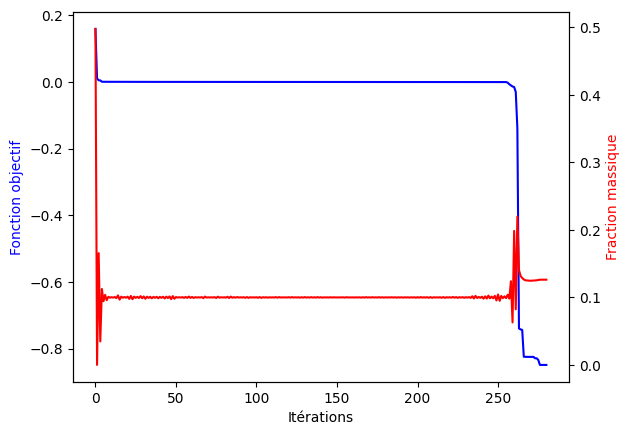

In [24]:
# Evolution de la fonction objectif et de la masse au cours de l'optimisation

ax1 = plt.plot(objectiveHistory, color = 'b')   
plt.ylabel('Fonction objectif', color = 'b')
plt.xlabel('Itérations')
ax2 = plt.gca().twinx()
ax2.plot(massHistory, color = 'r')
plt.ylabel('Fraction massique', color = 'r')
plt.show()